<a href="https://colab.research.google.com/github/Lalith2005reddy/HDR_Image_Segmentation/blob/main/Deeplab_model_on_Video_Version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


<ipython-input-6-fb553fc37918>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/best_exposure_segmentation_model_ph

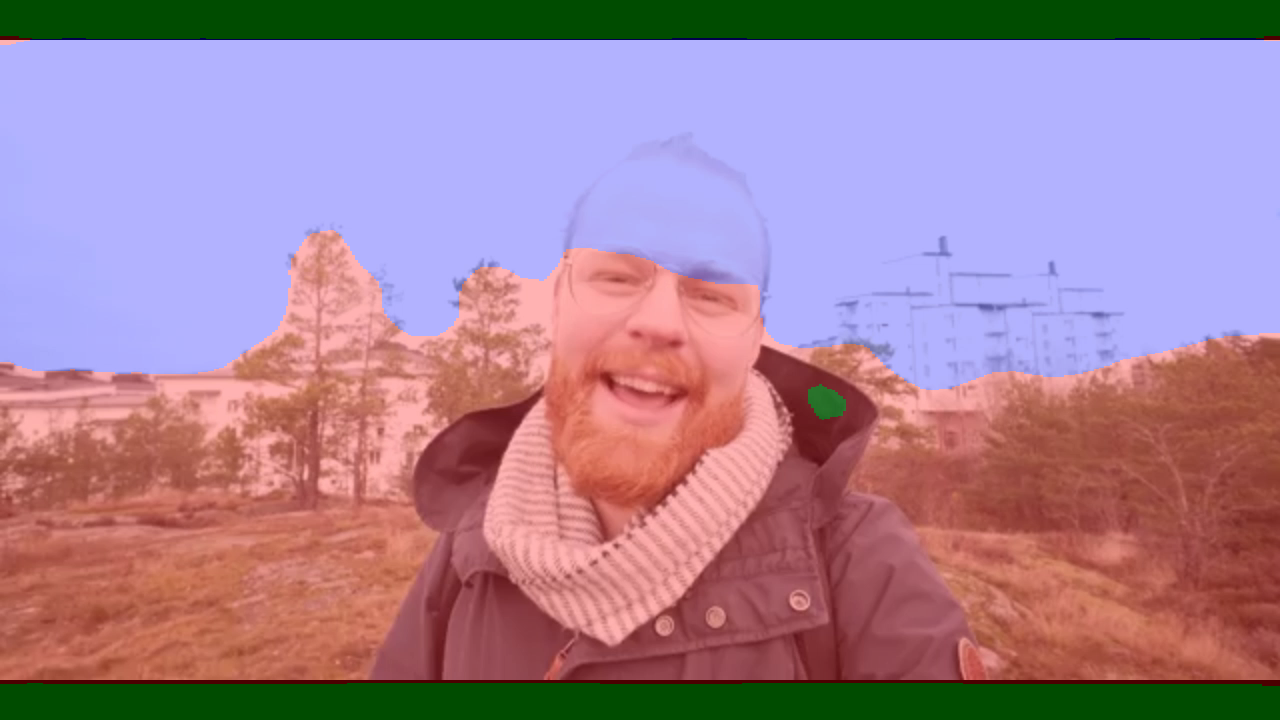

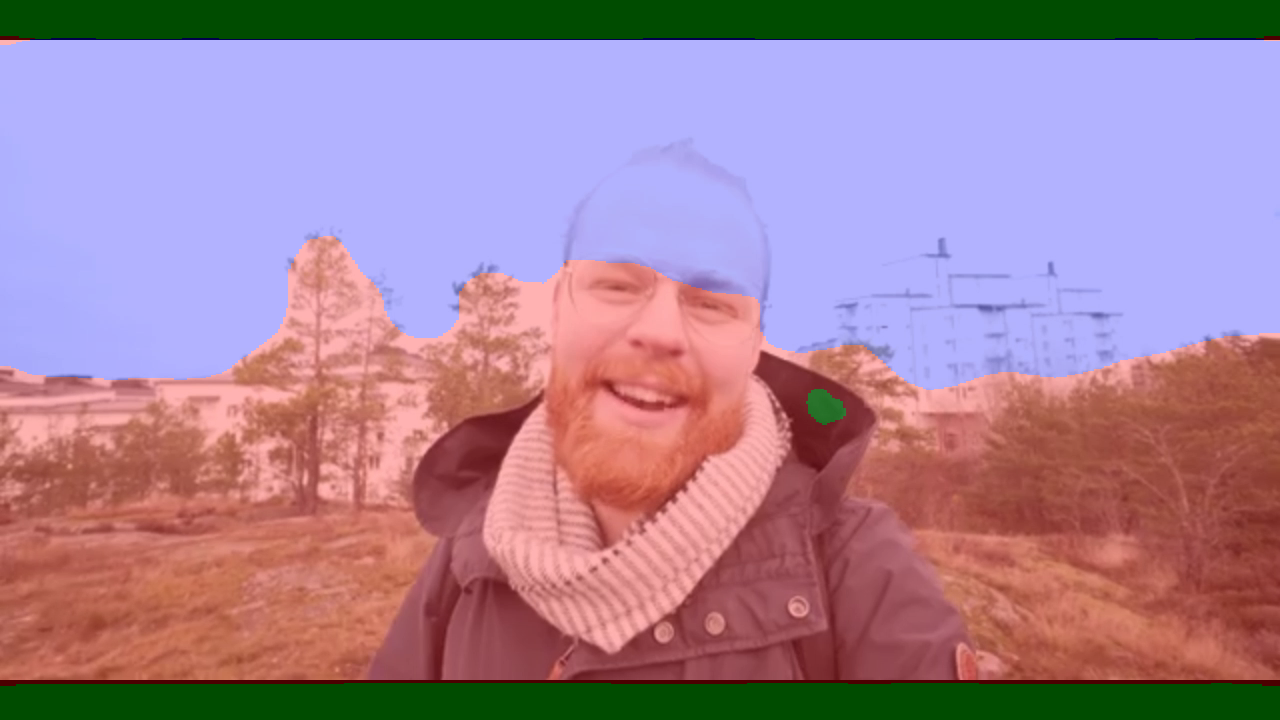

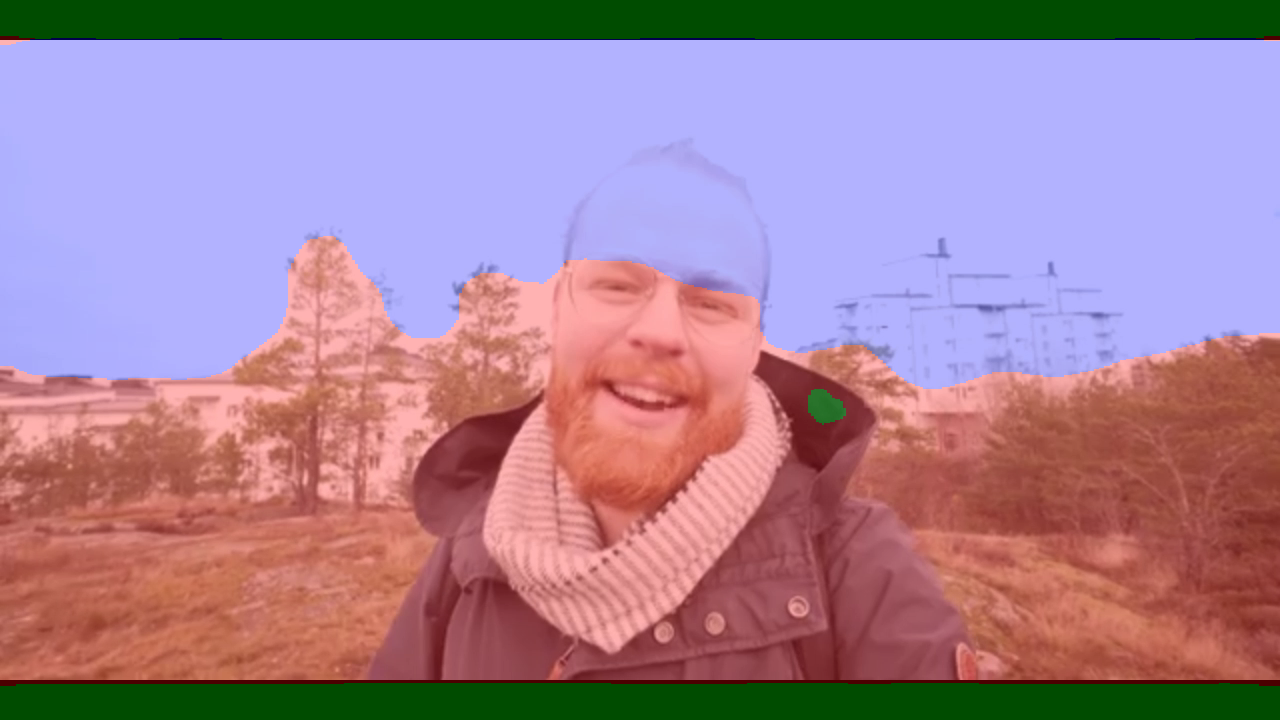

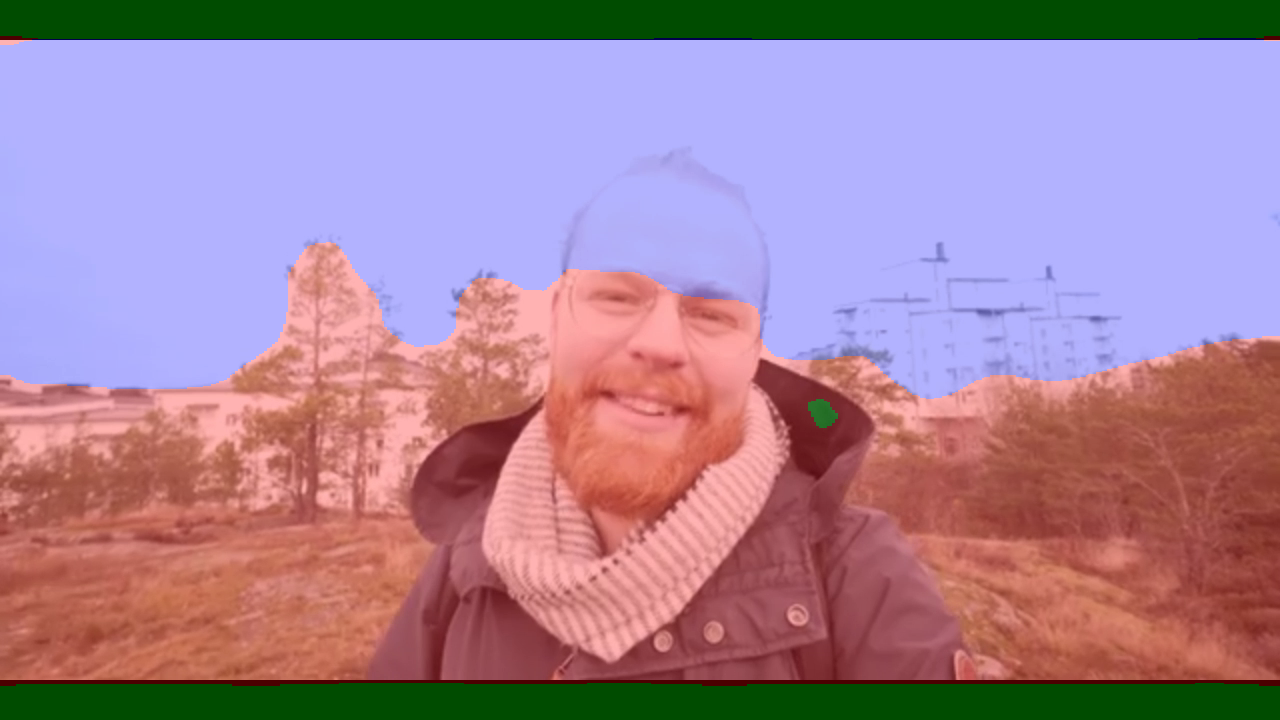

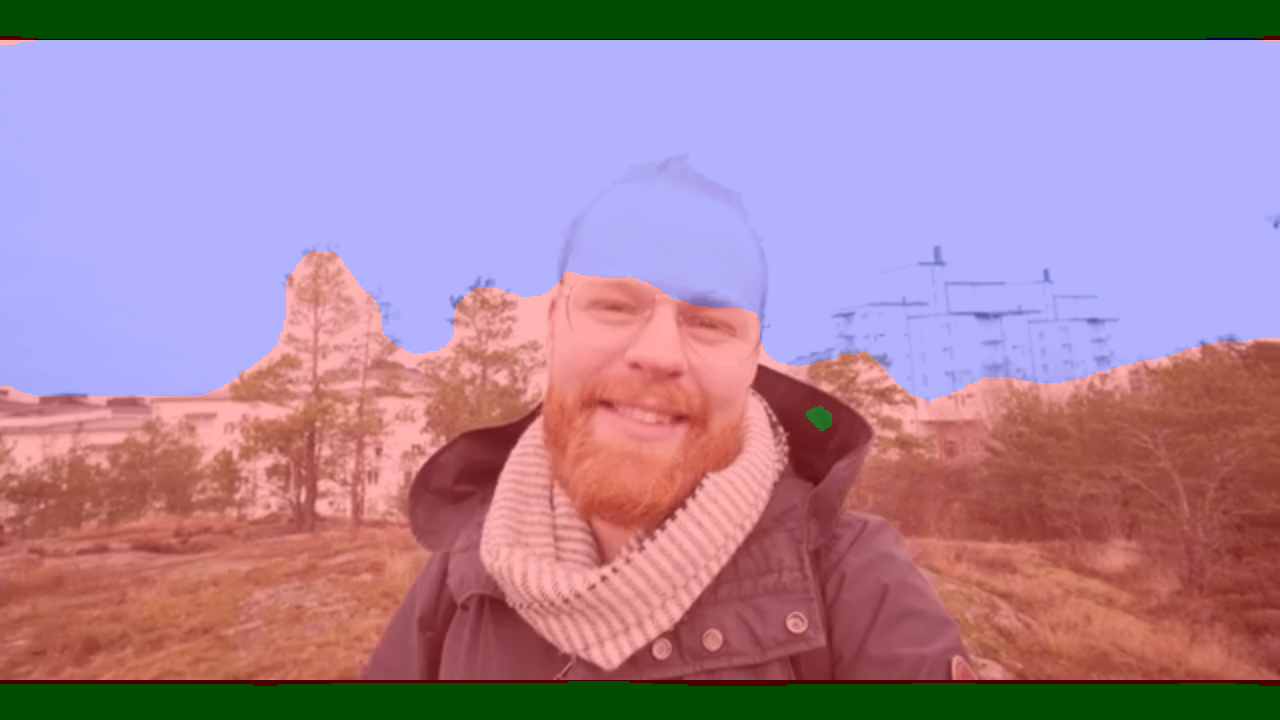

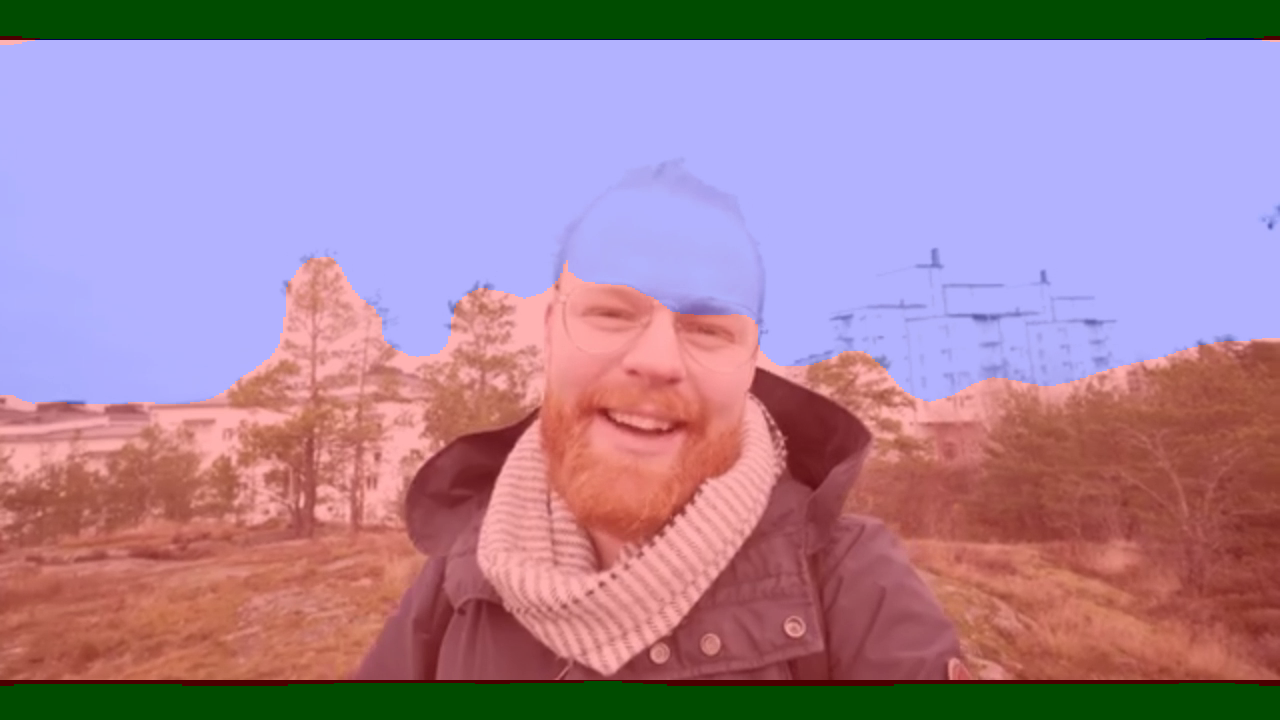

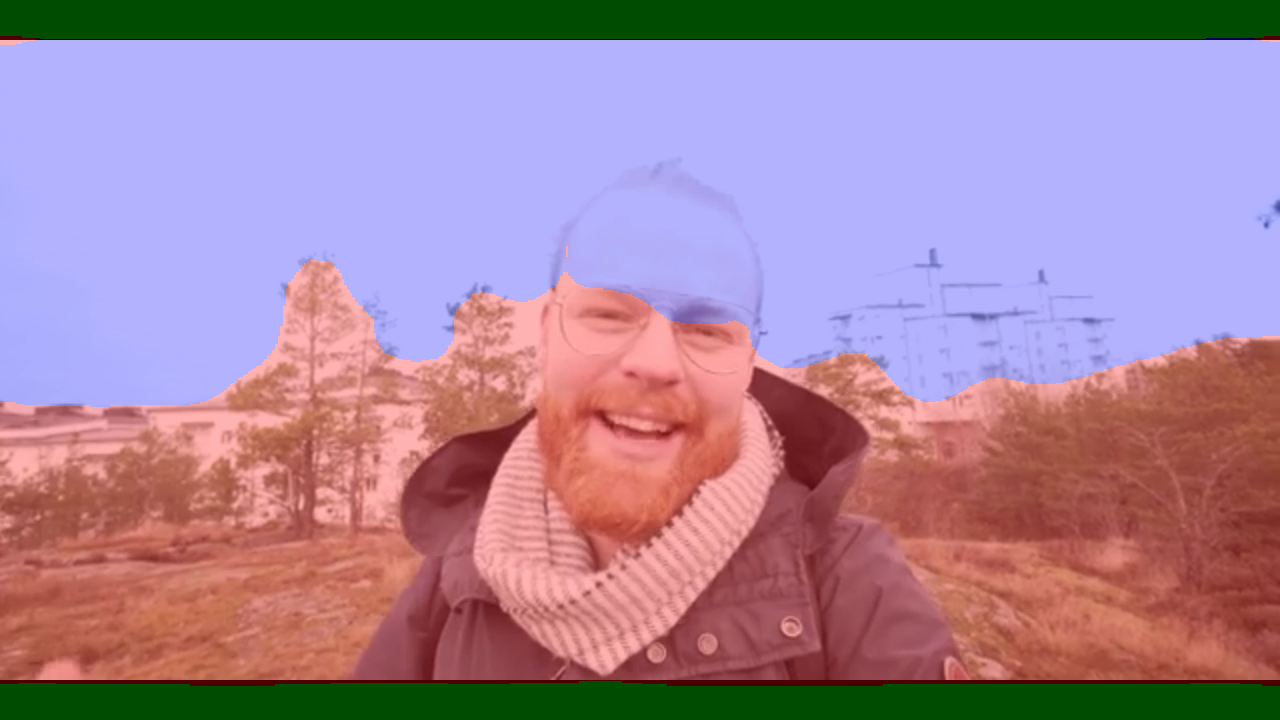

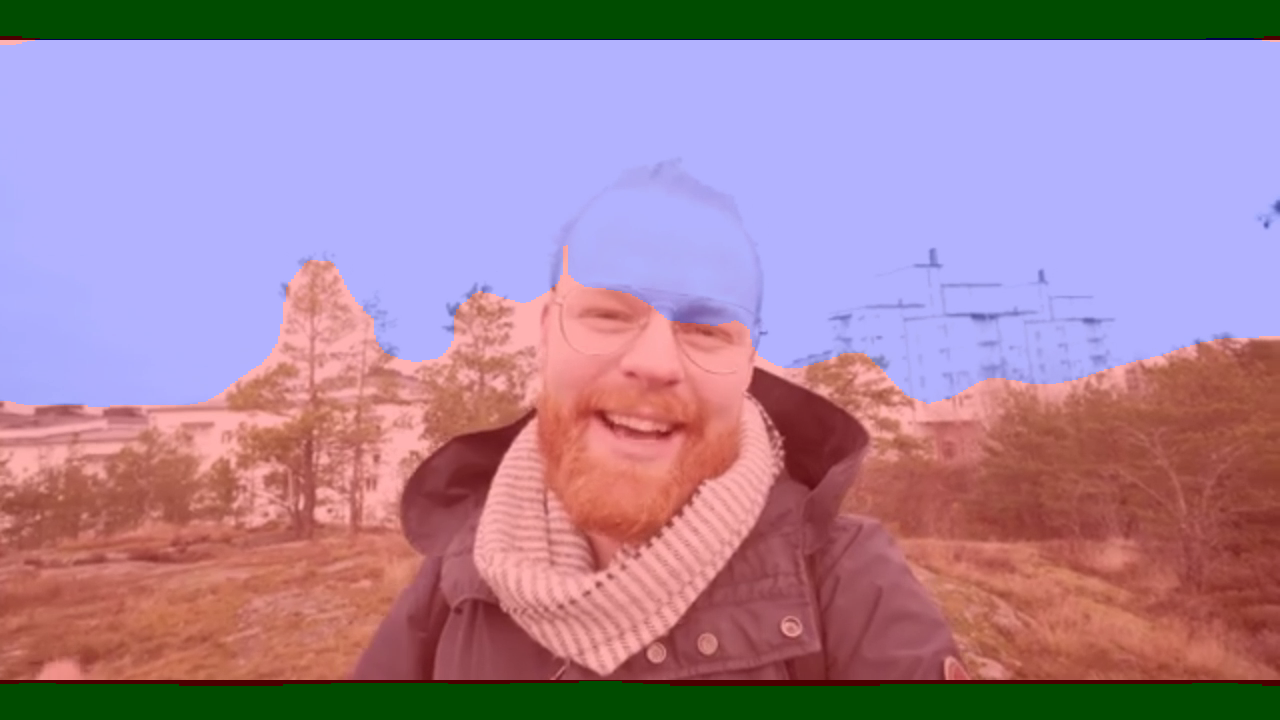

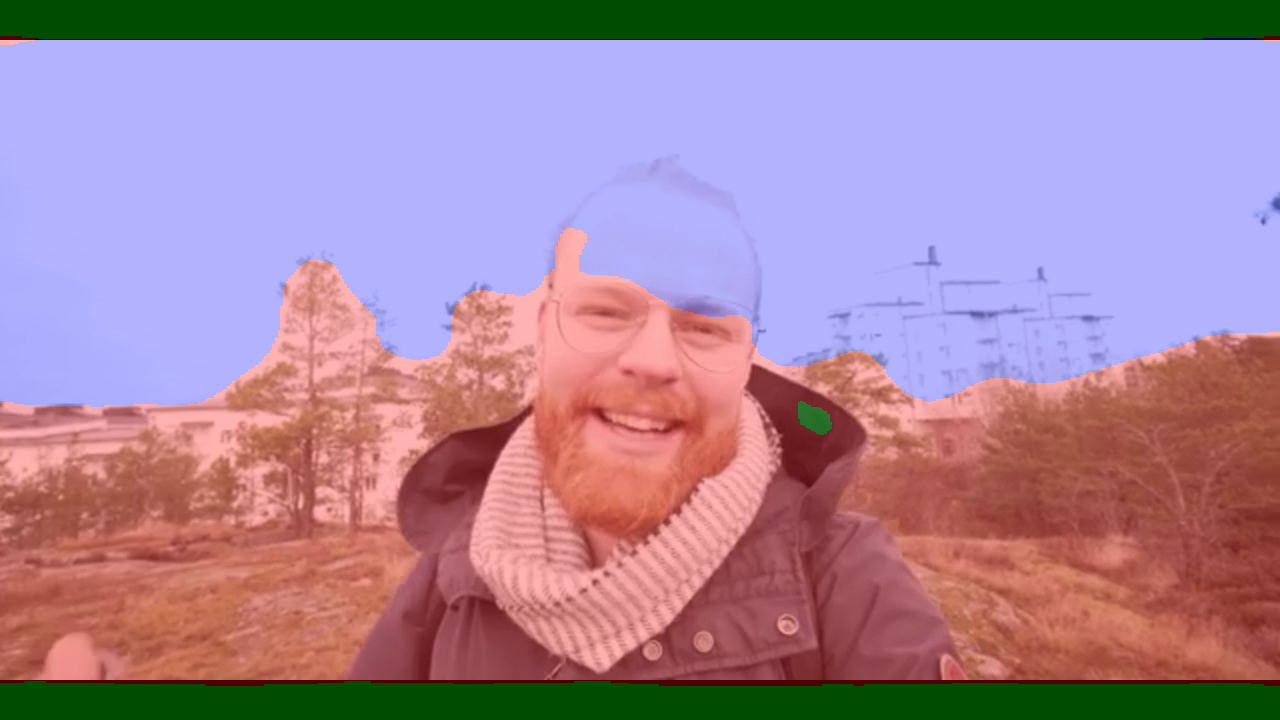

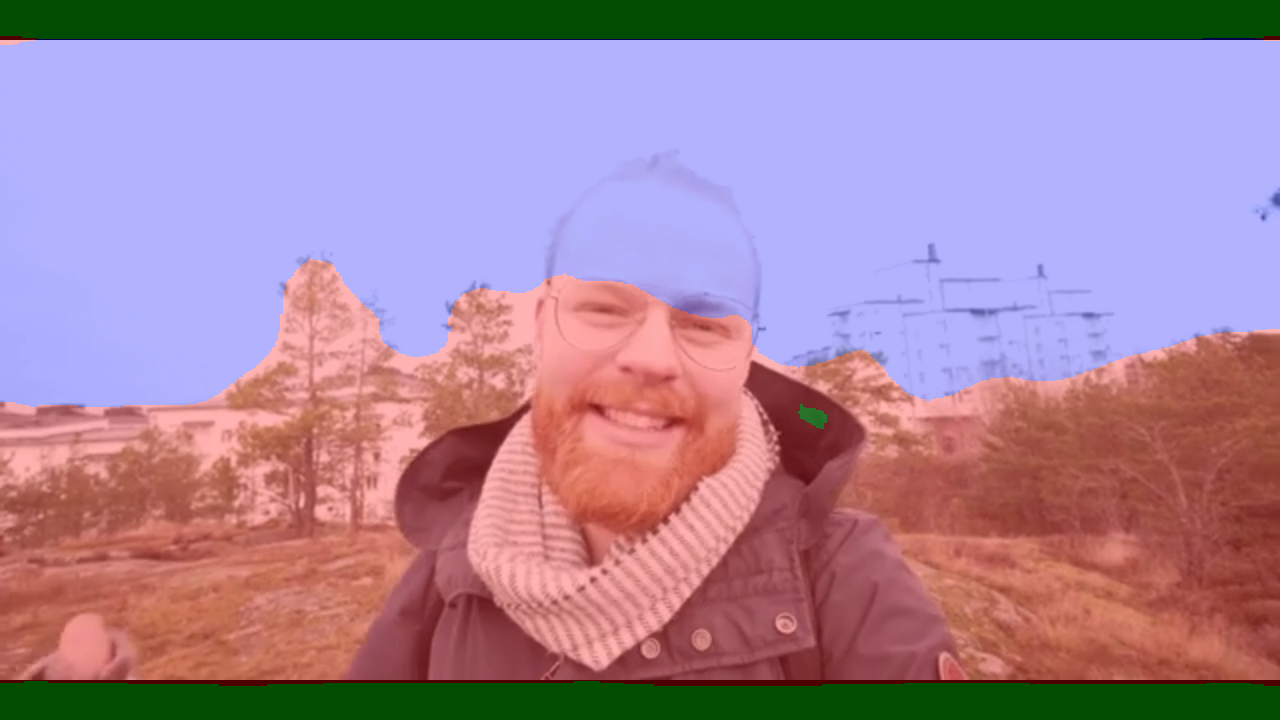

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
from google.colab.patches import cv2_imshow  # Use this for displaying images in Colab

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(weights=None)  # Use `weights=None`
model.classifier[4] = nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # 3 classes: overexposed, underexposed, correctly exposed

# Load model weights and ignore the aux_classifier keys
model.load_state_dict(torch.load('/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'), strict=False)

model.to(device)
model.eval()

# Transform for the input video frame
def transform_frame(frame):
    frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    transform = transforms.Compose([
        transforms.Resize((480, 480)),  # Resize the frame to the input size of the model
        transforms.ToTensor()
    ])
    return transform(frame).unsqueeze(0).to(device)

# Process a video and apply the model to each frame
def process_video(video_path, model, output_video_path=None):
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # Get video details
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object if saving output
    if output_video_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End the loop if no frame is returned

        # Apply transformation to frame
        transformed_frame = transform_frame(frame)

        # Model prediction
        with torch.no_grad():
            output = model(transformed_frame)['out']
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Resize the predicted mask to the original frame size
        pred_mask_resized = cv2.resize(pred_mask, (width, height), interpolation=cv2.INTER_NEAREST)

        # Create a colored mask for visualization
        colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
        colored_mask[pred_mask_resized == 0] = [0, 0, 0]   # black for correctly exposed
        colored_mask[pred_mask_resized == 1] = [0, 255, 0]   #green  for overexposed
        colored_mask[pred_mask_resized == 2] = [255, 0, 0]   #red  for underexposed

        # Overlay mask on the original frame
        output_frame = cv2.addWeighted(frame, 0.7, colored_mask, 0.3, 0)

        # Show the frame using cv2_imshow instead of cv2.imshow
        cv2_imshow(output_frame)

        # Save the frame to the output video if required
        if output_video_path:
            out.write(output_frame)

        # Break the loop on 'q' key press (Not required in Colab)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Release everything when done
    cap.release()
    if output_video_path:
        out.release()
    cv2.destroyAllWindows()

# Example usage: process the video
process_video('/content/drive/MyDrive/test_video_deeplab.mp4', model, 'output_video_segmented.mp4')